In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis/')

In [2]:
import pandas as pd
import TimeSeriesAnalysis.tsa_lth.analysis as analysis
import TimeSeriesAnalysis.tsa_lth.modelling as modelling
import TimeSeriesAnalysis.tsa_lth.tests as tests
from TimeSeriesAnalysis.tsa_lth.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pylab

In [3]:
def getARMA(data, A=0, C=0):
    A_free=A
    C_free=C
    model = modelling.PEM(data, A=A, C=C)
    if isinstance(A, int):
        A_free = [1]*(A+1)
    if isinstance(C, int):
        C_free = [1]*(C+1)
        print(C_free)
    model.set_free_params(A_free=A_free, C_free=C_free)
    model_fitted = model.fit(method='LS', bh=False)
    model_fitted.summary()
    return model_fitted

def checkNormal(data, remove=False, title=None):
    if remove:
        data = data[remove:]
    tests.check_if_normal(data)
    stats.probplot(data, dist="norm", plot=pylab)
    # variable = [ i for i, j in locals().items() if j == data][0]
    if title:
        plt.title(title)
    pylab.show()
    
    
def analyzeARMA(x, A=0, C=0, noLags=50, titleStr=None, return_val=False, normal_test=True):
    model = getARMA(x, A=A, C=C)
    if isinstance(A, int): len_A = A
    else: len_A = len(A)
    if isinstance(C, int): len_C = C
    else: len_C = len(C)
    remove=max(len_A, len_C)
    res = model.resid
    acf_est, pacf_est = analysis.plotACFnPACF(res,noLags=noLags,titleStr=titleStr, return_val=True)
    tests.whiteness_test(res)
    if normal_test:
        checkNormal(acf_est, remove=remove, title='ACF')
        checkNormal(pacf_est, remove=remove, title='PACF')
    if return_val:
        return model, acf_est, pacf_est

In [5]:
# Load data and get parameters
svedala = analysis.mat2np('./data/svedala.mat')
A = [1, -1.79, 0.84] ;
C = [1, -0.18, -0.11 ] ;
k = 1
Fk, Gk = modelling.polydiv(C, A, k)
yhat_k = modelling.filter(Gk, C, svedala, remove=max(len(Gk), len(C)))
pred_error = svedala[len(svedala)-len(yhat_k):] - yhat_k
noise_var = np.var(pred_error)
print(f'Estimate noise variance is {round(noise_var,6)}')

Estimate noise variance is 0.375095


## 3 step prediction

**Q**: What is the estimated mean and the expectation of the prediction error
for each of these cases? \
**A**: Estimated mean is -0.0110, while expectation is 0

In [7]:
# k = 3 step prediction
k=3
F3, G3 = modelling.polydiv(C, A, k)
yhat_3 = modelling.filter(G3, C, svedala, remove=max(len(G3), len(C)))
pred_error_3 = svedala[len(svedala)-len(yhat_3):] - yhat_3
print(f'Estimate mean prediction error is {round(np.mean(pred_error_3),6)}')

Estimate mean prediction error is -0.005344


**Q**: Assuming that the estimated noise variance is the true one, what is the
theoretical variance of the prediction error? Using the same noise
variance, what is the estimated variance of the prediction error?
Comment on the the differences in these variances. \
**A**: The estimated noise variance is the variance of the prediction error (0.3751) when k=1. The theoretical variance is 2.7473

In [8]:
theo_var_3 = sum([i**2 for i in F3]) * noise_var
print(f'Theoretical prediction error variance with 3 steps is {round(theo_var_3,4)}')

Theoretical prediction error variance with 3 steps is 2.7473


In [9]:
# Confidence interval
K3_CI = [-1.96*np.sqrt(theo_var_3), 1.96*np.sqrt(theo_var_3)]
print(f'Confidence interval for {k} step prediction process is: {[round(i,4) for i in K3_CI]}')

Confidence interval for 3 step prediction process is: [-3.2487, 3.2487]


In [10]:
# Percentage of prediction error outside confidence interval
perc_3 = 1-sum([K3_CI[0] <= i <= K3_CI[1] for i in pred_error])/len(pred_error)
print(f'Percentage of prediction error outside confidence interval: {round(perc_3, 4)}')

Percentage of prediction error outside confidence interval: 0.0


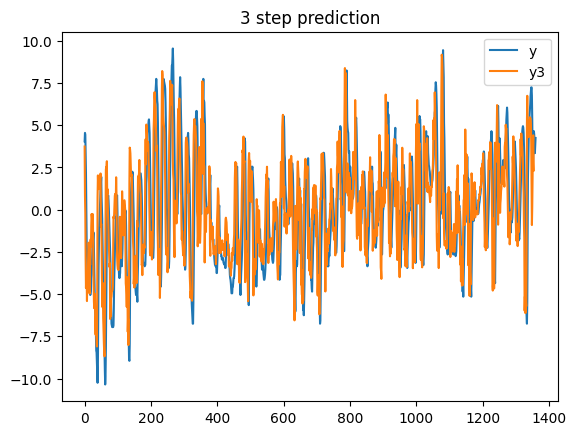

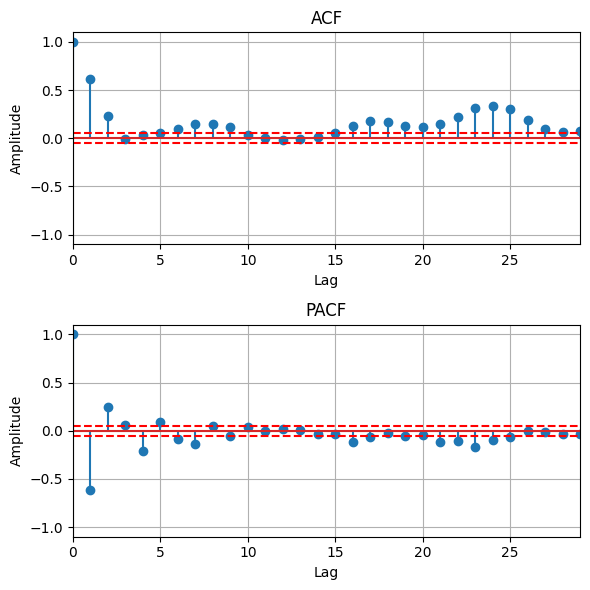

In [11]:
plt.plot(svedala, label='y')
plt.plot(yhat_3, label='y3')
plt.legend()
plt.title('3 step prediction')
plt.show()

analysis.plotACFnPACF(pred_error_3)

## 26 step prediction

In [14]:
# k = 26 step prediction
k=26
F26, G26 = modelling.polydiv(C, A, k)
yhat_26 = modelling.filter(G26, C, svedala, remove=max(len(G26), len(C)))
pred_error_26 = svedala[len(svedala)-len(yhat_26):] - yhat_26
print(f'Estimate prediction error is {round(np.mean(pred_error_26),6)}')

Estimate prediction error is 0.044661


In [15]:
theo_var26 = sum([i**2 for i in F26]) * noise_var
print(f'Theoretical prediction error variance with 3 steps is {round(theo_var26,4)}')

Theoretical prediction error variance with 3 steps is 12.6169


In [16]:
# Confidence interval
K26_CI = [-1.96*np.sqrt(theo_var26), 1.96*np.sqrt(theo_var26)]
print(f'Confidence interval for {k} step prediction process is: {[round(i,4) for i in K26_CI]}')

Confidence interval for 26 step prediction process is: [-6.962, 6.962]


In [17]:
# Percentage of prediction error outside confidence interval
perc_26 = 1-sum([K26_CI[0] <= i <= K26_CI[1] for i in pred_error_26])/len(pred_error_26)
print(f'Percentage of prediction error outside confidence interval: {round(perc_26, 4)}')

Percentage of prediction error outside confidence interval: 0.0345


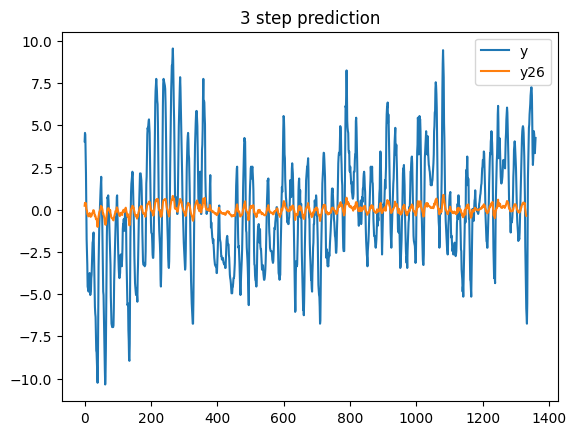

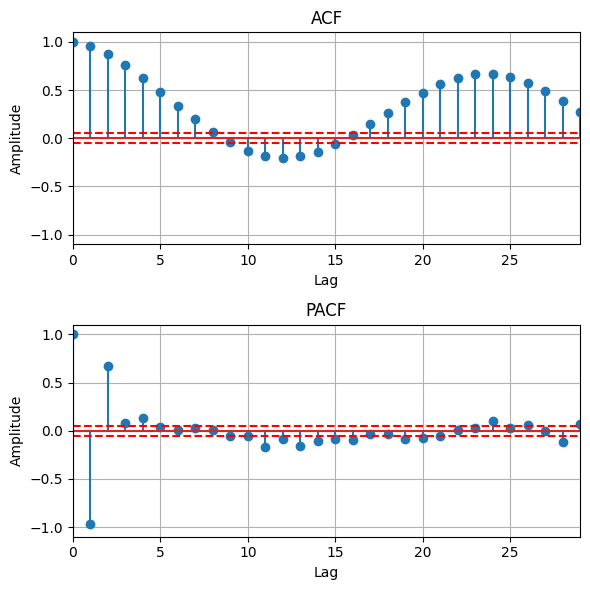

In [18]:
plt.plot(svedala, label='y')
plt.plot(yhat_26, label='y26')
plt.legend()
plt.title('3 step prediction')
plt.show()

analysis.plotACFnPACF(pred_error_26)

# Question 5

In [19]:
sturup = analysis.mat2np('./data/sturup.mat')
A = [1, -1.49, 0.57] ;
B = [0, 0, 0, 0.28, -0.26] ; # Since k <= d, Fhat is array of 0
C = [1] ;

In [20]:
k=3
F3, G3 = modelling.polydiv(C, A, k)
BF3 = np.convolve(B, F3)
Fhat3, Ghat3 = modelling.polydiv(BF3, C, k)
xhat3 = modelling.filter(G3, C, sturup)

In [21]:
yhat3_wrong = modelling.filter(Ghat3, C, sturup) + modelling.filter(G3, C, svedala)
yhat3_correct = yhat3_wrong + modelling.filter(Fhat3, [1],sturup)
remove = max(len(Fhat3), len(Ghat3), len(G3), 1)
yhat3_wrong = yhat3_wrong[remove:]
yhat3_correct = yhat3_correct[remove:]

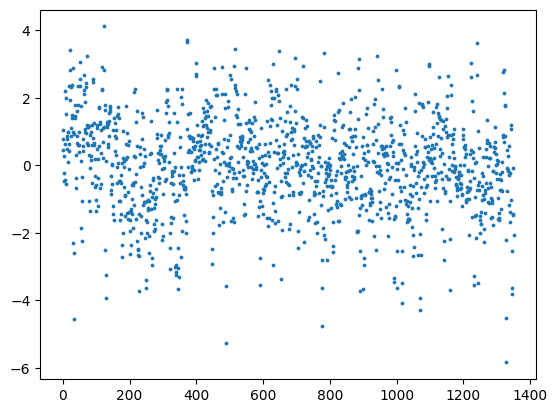

In [22]:
plt.scatter(range(len(yhat3_correct)),yhat3_correct-svedala[remove:], s=3)
plt.show()

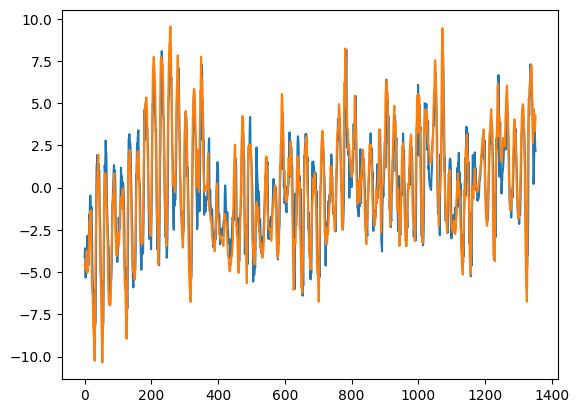

In [23]:
plt.plot(yhat3_wrong)
plt.plot(svedala[remove:])

In [24]:
k=26
F26, G26 = modelling.polydiv(C, A, k)
BF26 = np.convolve(B, F26)
Fhat26, Ghat26 = modelling.polydiv(BF26, C, k)
xhat26 = modelling.filter(G26, C, sturup)

In [25]:
yhat26_wrong = modelling.filter(Ghat26, C, sturup) + modelling.filter(G26, C, svedala)
yhat26_correct = yhat26_wrong + modelling.filter(Fhat26, [1],sturup)
remove26 = max(len(Fhat26), len(Ghat26), len(G26), 1)
yhat26_wrong = yhat26_wrong[remove26:]
yhat26_correct = yhat26_correct[remove26:]

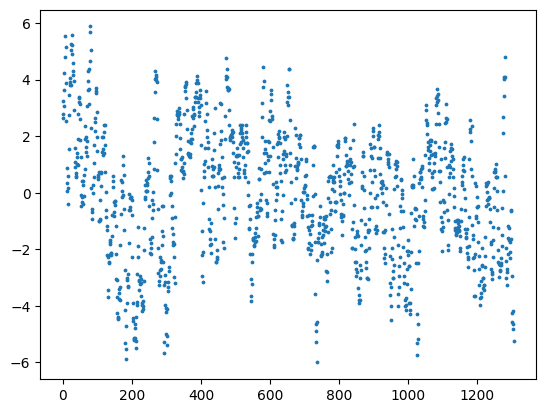

In [26]:
plt.scatter(range(len(yhat26_correct)),yhat26_correct-svedala[remove26:], s=3)
plt.show()

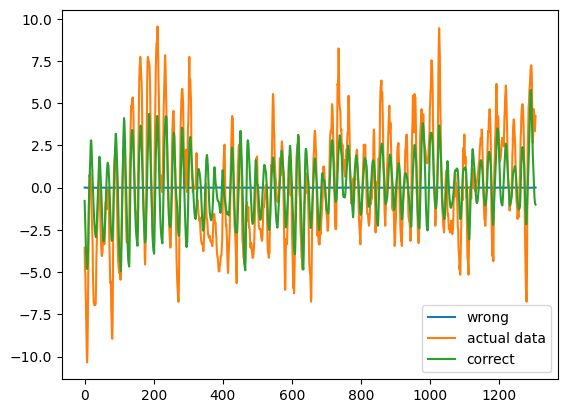

In [27]:
plt.plot(yhat26_wrong, label='wrong')
plt.plot(svedala[remove26:], label='actual data')
plt.plot(yhat26_correct, label='correct')
plt.legend()

In the case when k > d, the correct estimate has a big difference compared to the wrong estimation. The wrong estimation seems to only be estimating based on the mean of the data, while the correct estimation seems to be folowing the trend.

## SARIMA

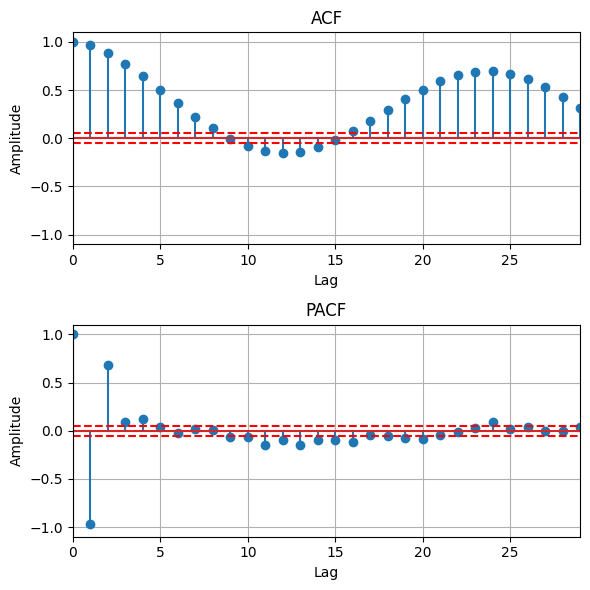

In [28]:
analysis.plotACFnPACF(svedala)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.7259(±0.0191)·z⁻²⁴

Polynomial orders: nA = 24
Number of free coefficients: 1
Fit to estimation data (NRMSE): 30.83%
FPE : 5.361  MSE : 5.363
AIC : 6041.77   BIC : 6046.968



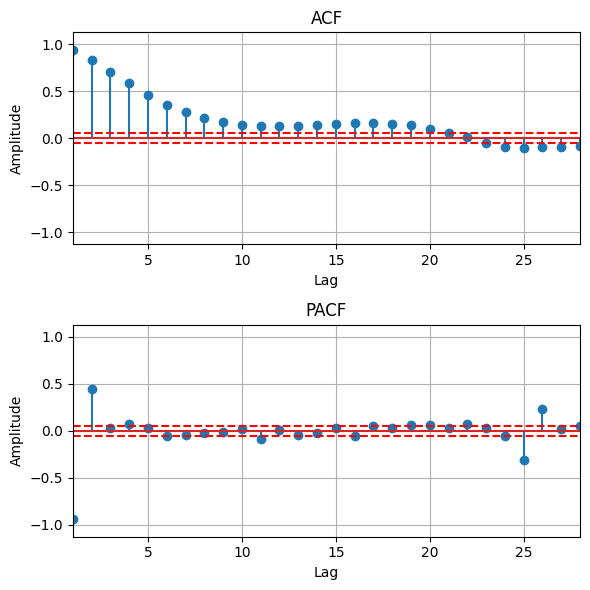

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 4232.78 < 31.41)
  McLeod-Li test:        False (white if 2188.33 < 31.41)
  Monti test:            False (white if 1495.01 < 31.41)
  Sign change test:      False (white if 0.10 in [0.47,0.53])


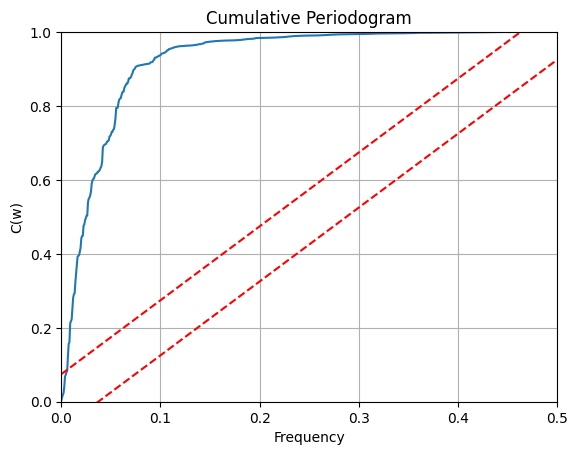

In [29]:
# Season of 24
AS = [1] + [0]*23 + [1]
ordC = 0
model_24 = modelling.estimateARMA(svedala, A=AS)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.3675(±0.0245)·z⁻¹ + 0.4508(±0.0246)·z⁻²

Polynomial orders: nA = 2
Number of free coefficients: 2
Fit to estimation data (NRMSE): 70.36%
FPE : 0.472  MSE : 0.47
AIC : 2785.342   BIC : 2795.736



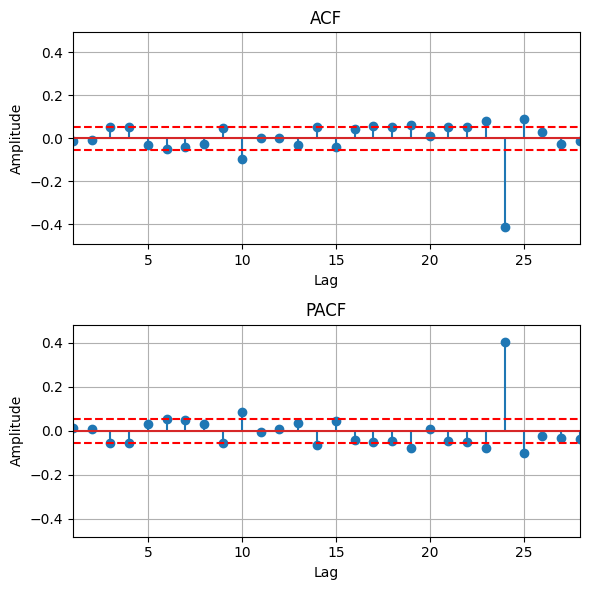

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 54.96 < 31.41)
  McLeod-Li test:        False (white if 53.73 < 31.41)
  Monti test:            False (white if 58.34 < 31.41)
  Sign change test:      True (white if 0.49 in [0.47,0.53])


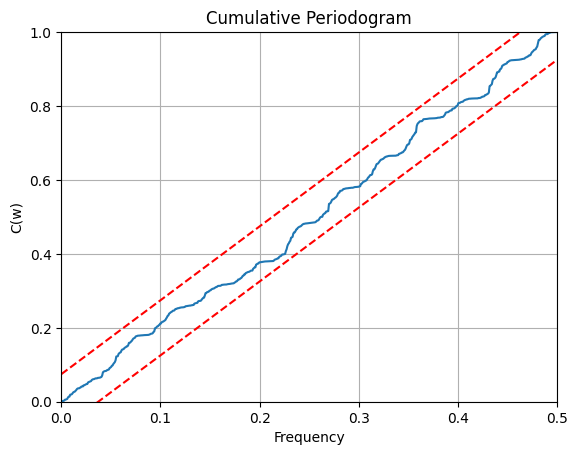

In [30]:
# AR(1) seems reasonable
ordA=2
model_24_2 = modelling.estimateARMA(model_24.resid,A=ordA)

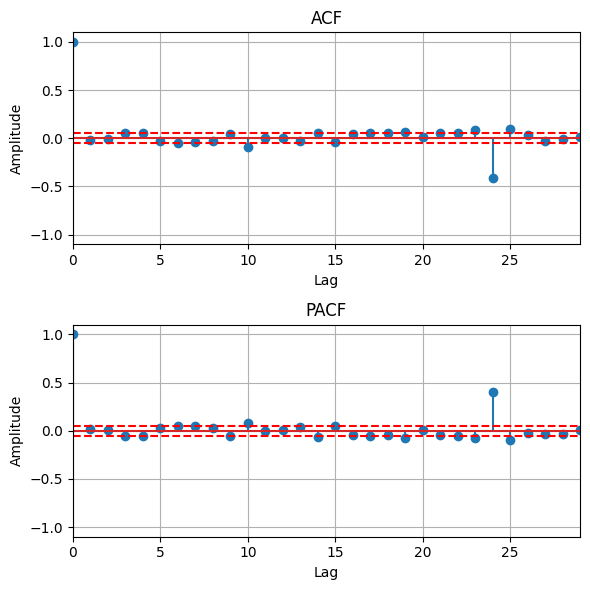

In [31]:
analysis.plotACFnPACF(model_24_2.resid)

Discrete-time MA model: y(t) = C(z)e(t)

C(z) = 1.0 - 0.4859(±0.0242)·z⁻²⁴

Polynomial orders: nC = 24
Number of free coefficients: 1
Fit to estimation data (NRMSE): 11.07%
FPE : 0.372  MSE : 0.372
AIC : 2469.803   BIC : 2474.999



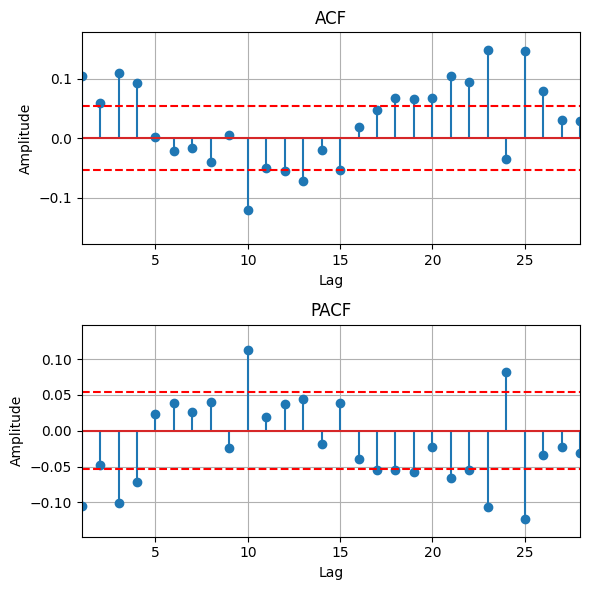

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 110.21 < 31.41)
  McLeod-Li test:        False (white if 63.82 < 31.41)
  Monti test:            False (white if 84.96 < 31.41)
  Sign change test:      False (white if 0.42 in [0.47,0.53])


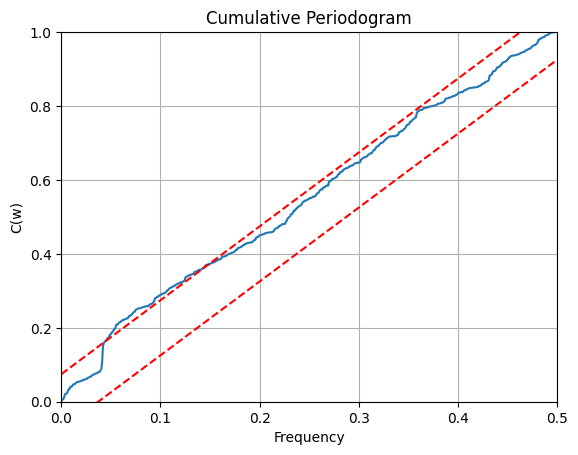

In [32]:
# Include an MA 24th term
C = [1] + [0]*23 + [1]
smth = model_24_2.resid
model_final = modelling.estimateARMA(smth,A=0,C=C)

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.4358(±0.0238)·z⁻¹ + 0.4893(±0.0238)·z⁻² - 0.8991(±0.0249)·z⁻²⁴ + 1.243(±0.0512)·z⁻²⁵ - 0.3908(±0.0321)·z⁻²⁶
C(z) = 1.0 - 0.8147(±0.0333)·z⁻²⁴

Polynomial orders: nA = 26    nC = 24
Number of free coefficients: 6
Fit to estimation data (NRMSE): 82.86%
FPE : 0.332  MSE : 0.33
AIC : 2318.541   BIC : 2349.721



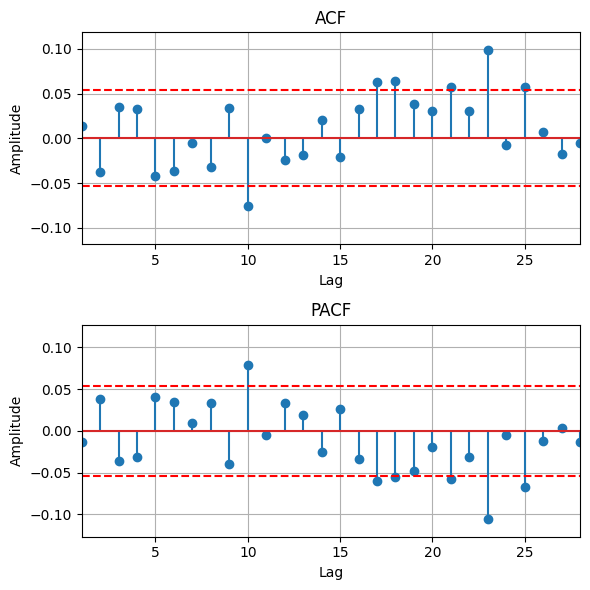

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 38.17 < 31.41)
  McLeod-Li test:        False (white if 67.74 < 31.41)
  Monti test:            False (white if 38.90 < 31.41)
  Sign change test:      True (white if 0.48 in [0.47,0.53])


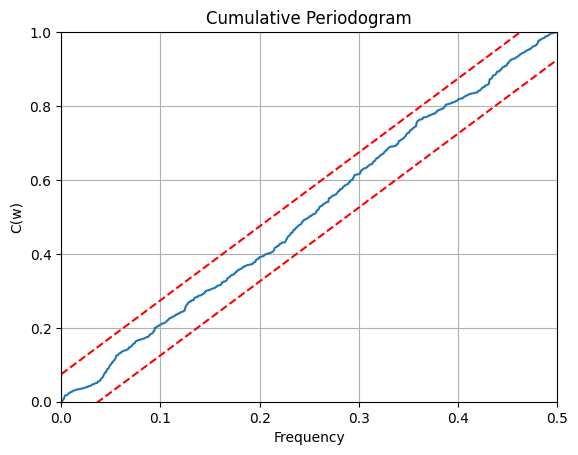

In [33]:
# We try estimating all the parameters at once
ordA=[1,1,1] + [0]*21 + [1,1,1]
ordC=[1] + [0]*23 + [1]
model_svedala = modelling.estimateARMA(svedala, A=ordA, C=ordC)

In [43]:
# Load data and get parameters
svedala = analysis.mat2np('./data/svedala.mat')
A = model_svedala.A ;
C = model_svedala.C ;
k = 1
Fk, Gk = modelling.polydiv(C, A, k)
yhat_k = modelling.filter(Gk, C, svedala, remove=max(len(Gk), len(C)))
pred_error = svedala[len(svedala)-len(yhat_k):] - yhat_k
noise_var = np.var(pred_error)
print(f'Estimate noise variance is {round(noise_var,6)}')

Estimate noise variance is 0.329662


In [44]:
# k = 3 step prediction
k=3
F3, G3 = modelling.polydiv(C, A, k)
yhat_3 = modelling.filter(G3, C, svedala, remove=max(len(G3), len(C)))
pred_error_3 = svedala[len(svedala)-len(yhat_3):] - yhat_3
theo_var_3 = sum([i**2 for i in F3]) * noise_var
print(f'Theoretical prediction error variance with {k} steps is {round(theo_var_3,4)}')

Theoretical prediction error variance with 3 steps is 1.824


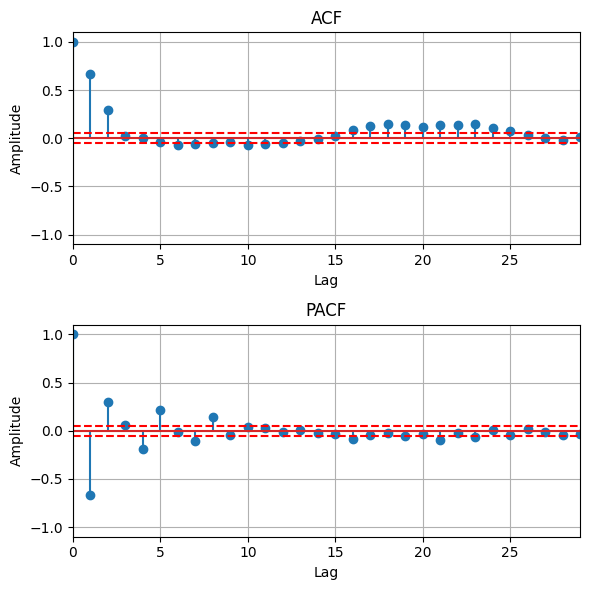

In [47]:
analysis.plotACFnPACF(pred_error_3)

In [39]:
# k = 26 step prediction
k=26
F26, G26 = modelling.polydiv(C, A, k)
yhat_26 = modelling.filter(G26, C, svedala, remove=max(len(G26), len(C)))
pred_error_26 = svedala[len(svedala)-len(yhat_26):] - yhat_26
theo_var_26 = sum([i**2 for i in F26]) * noise_var
print(f'Theoretical prediction error variance with {k} steps is {round(theo_var_26,4)}')
# print(f'Estimate mean prediction error is {round(np.mean(pred_error_3),6)}')

Theoretical prediction error variance with 26 steps is 6.1584


Yes, we get a smaller estimated prediction error variance compared to before.